# Autoencoder
512 -> 256 -> 128 -> 256 -> 512

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [22]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # Convolutional layers for downsampling
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)  # 512x512 -> 256x256
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)  # 256x256 -> 128x128

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Downsample to 256x256
        x = F.relu(self.conv2(x))  # Downsample to 128x128
        return x  # Output shape: (batch_size, 32, 128, 128)

In [23]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Transposed convolutional layers for upsampling
        self.convt1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)  # 128x128 -> 256x256
        self.convt2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)  # 256x256 -> 512x512

    def forward(self, x):
        x = F.relu(self.convt1(x))  # Upsample to 256x256
        x = torch.sigmoid(self.convt2(x))  # Upsample to 512x512, using sigmoid for normalized output in [0, 1]
        return x  # Output shape: (batch_size, 1, 512, 512)

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()  # Downsampling: 512x512 -> 128x128
        self.decoder = Decoder()  # Upsampling: 128x128 -> 512x512

    def forward(self, x):
        emb = self.encoder(x)  # Get compressed representation
        reconstructed = self.decoder(emb)  # Reconstruct input
        return reconstructed, emb

In [24]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for loading images from a single folder
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image file path
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        
        # Open the image
        image = Image.open(img_path).convert('L')  # Convert to grayscale (1 channel)
        
        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
        
        return image  # No labels needed, return only the image


In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure images are grayscale (if not already)
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Path to your folder containing images
folder_path = 'toys/train'

# Create the dataset
dataset = ImageDataset(folder_path, transform=transform)

# Create the DataLoader
batch_size = 16  # Adjust based on your GPU memory
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


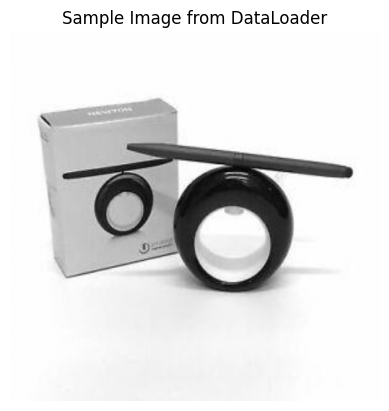

In [11]:
import matplotlib.pyplot as plt

# Get a batch of images from the DataLoader
images = next(iter(dataloader))

# Select the first image in the batch
image = images[7].cpu().numpy().squeeze()

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Sample Image from DataLoader")
plt.axis('off')
plt.show()

In [12]:
images.shape

torch.Size([16, 1, 512, 512])

In [16]:
# Initialize the AutoEncoder model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = AutoEncoder().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0

    for images in dataloader:
        images = images.to(device)  # Move images to the device (CPU/GPU)

        # Forward pass
        reconstructed, _ = autoencoder(images)

        # Compute reconstruction loss
        loss = criterion(reconstructed, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print epoch loss
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.1934
Epoch [2/20], Loss: 0.1011
Epoch [3/20], Loss: 0.0984
Epoch [4/20], Loss: 0.0972
Epoch [5/20], Loss: 0.0969
Epoch [6/20], Loss: 0.0971
Epoch [7/20], Loss: 0.0958
Epoch [8/20], Loss: 0.0957
Epoch [9/20], Loss: 0.0951
Epoch [10/20], Loss: 0.0961
Epoch [11/20], Loss: 0.0948
Epoch [12/20], Loss: 0.0953
Epoch [13/20], Loss: 0.0949
Epoch [14/20], Loss: 0.0950
Epoch [15/20], Loss: 0.0941
Epoch [16/20], Loss: 0.0942
Epoch [17/20], Loss: 0.0943
Epoch [18/20], Loss: 0.0937
Epoch [19/20], Loss: 0.0939
Epoch [20/20], Loss: 0.0936


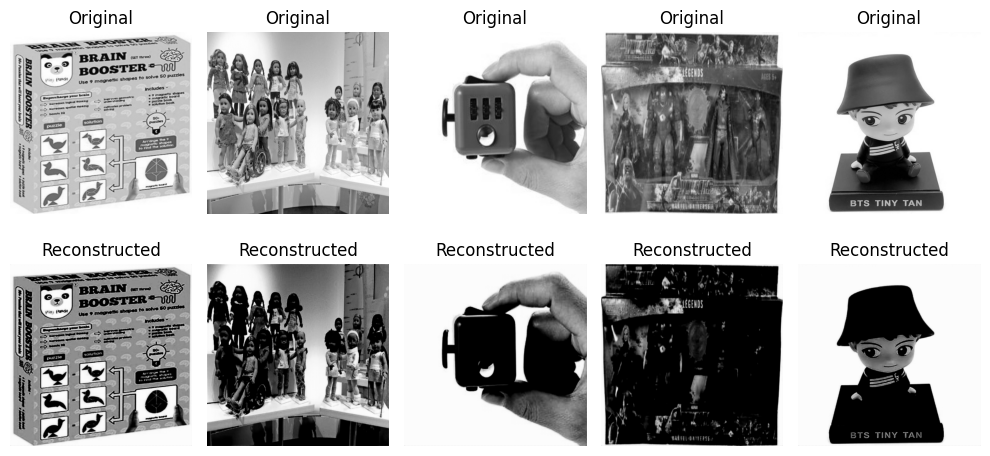

In [17]:
import matplotlib.pyplot as plt

# Switch to evaluation mode
autoencoder.eval()

# Get a batch of images from the DataLoader
images = next(iter(dataloader))
images = images.to(device)

# Reconstruct the images
with torch.no_grad():
    reconstructed, _ = autoencoder(images)

# Move images back to CPU for visualization
images = images.cpu().numpy()
reconstructed = reconstructed.cpu().numpy()

# Plot the original and reconstructed images
plt.figure(figsize=(10, 5))
for i in range(5):  # Show 5 samples
    # Original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i+2].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed[i+2].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [18]:
# Calculate reconstruction loss on the validation/test dataset
autoencoder.eval()
total_loss = 0

# Path to your folder containing images
folder_path = 'toys/test'

# Create the dataset
dataset_test = ImageDataset(folder_path, transform=transform)

# Create the DataLoader
batch_size = 16  # Adjust based on your GPU memory
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
with torch.no_grad():
    for images in dataloader_test:  
        images = images.to(device)
        reconstructed, _ = autoencoder(images)
        loss = nn.MSELoss()(reconstructed, images)
        total_loss += loss.item()

average_loss = total_loss / len(dataloader_test)
print(f"Reconstruction Loss (MSE): {average_loss:.4f}")


Reconstruction Loss (MSE): 0.1031


In [20]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Function to test the autoencoder on a random image
def test_autoencoder_on_image(image_path, autoencoder, device):
    # Load the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale if it's not already
    
    # Define the preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize((512, 512)),  # Resize to 512x512
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    # Preprocess the image
    input_image = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Run the image through the autoencoder
    autoencoder.eval()  # Set autoencoder to evaluation mode
    with torch.no_grad():
        reconstructed_image, _ = autoencoder(input_image)
    
    # Move tensors back to CPU and remove batch dimension
    input_image = input_image.squeeze(0).cpu().numpy()
    reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()

    # Denormalize images for visualization (from [-1, 1] to [0, 1])
    input_image = (input_image * 0.5) + 0.5
    reconstructed_image = (reconstructed_image * 0.5) + 0.5

    # Plot the original and reconstructed images
    plt.figure(figsize=(8, 4))
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0], cmap='gray')  # `input_image[0]` because it's a single-channel image
    plt.title("Original Image")
    plt.axis('off')
    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image[0], cmap='gray')  # `reconstructed_image[0]` for single channel
    plt.title("Reconstructed Image")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


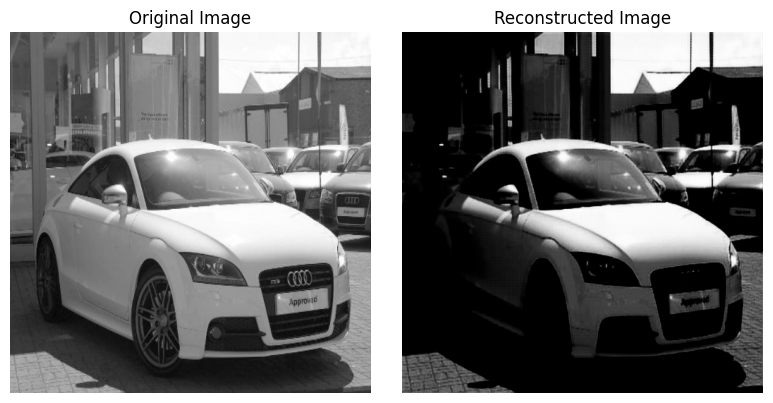

In [21]:
image_path = 'image0000.jpg'
autoencoder = autoencoder.to(device)
test_autoencoder_on_image(image_path, autoencoder, device)
